In [1]:
from prettytable import PrettyTable
from matplotlib import pyplot as plot
from math import fabs

In [2]:
# -- Source data --
rod_radius = 0.5            # Radius of the rod
first_cond_coeff = 0.2      # Parameter for conductivity coefficient
second_cond_coeff = 0.5     # Ditto
begin_transf_coeff = 1e-2   # Heat transfer coefficient (start point)
end_transf_coeff = 9e-3     # Ditto (end point)
rod_length = 10             # Rod length
env_temperature = 300       # Environment temperature
heat_stream_density = 100   # Heat stream density

N = 25

In [3]:
def get_alpha(x, a, b):
    return a / (x - b)

In [4]:
# To calculate the coefficients A and C of the Thomas Algorithm:
def get_A_or_C(first_k, second_k):
    return 2 * first_k * second_k / (first_k + second_k)

In [5]:
class ThomasAlgorithmCoefficients:
    def __init__(self):
        self.A = []
        self.B = []
        self.C = []
        self.F = []

        
class BoundaryConditionParameters:
    def __init__(self):
        self.coefficients = ThomasAlgorithmCoefficients()
        
        self.K0 = 0   # For the boundary condition on the left
        self.M0 = 0   # For the boundary condition on the left
        self.P0 = 0   # For the boundary condition on the left
        
        self.KN = 0   # For the boundary condition on the right
        self.MN = 0   # For the boundary condition on the right
        self.PN = 0   # For the boundary condition on the right
        
        self.n = 0    # The number of equations

In [6]:
def runthru_coefficients(data, n, t):
    # Runthru coefficients:
    xi = [0] * (n + 1)
    et = [0] * (n + 1)
    xi[1] = -data.M0 / data.K0
    et[1] = data.P0 / data.K0
    # Forward run:
    for i in range(2, n + 1):
        xi[i] = data.coefficients.C[i - 1] / (data.coefficients.B[i - 1] - data.coefficients.A[i - 1] * xi[i - 1])
        et[i] = (data.coefficients.F[i - 1] + data.coefficients.A[i - 1] * et[i - 1]) / (data.coefficients.B[i - 1] - data.coefficients.A[i - 1] * xi[i - 1])
    t[n] = (data.PN - data.MN * et[n]) / (data.KN + data.MN * xi[n])
    # Reverse run:
    for i in range(n - 1, -1, -1):
        t[i] = xi[i + 1] * t[i + 1] + et[i + 1]
    pass

In [7]:
def calculate():
    b_coeff = end_transf_coeff * rod_length / (end_transf_coeff - begin_transf_coeff)
    a_coeff = -1 * begin_transf_coeff * b_coeff
    T = [500] * (N + 1)
    x = []
    T_old = 500
    h = rod_length / (N - 1)
    run_data = BoundaryConditionParameters()
    
    while True:
        T_old = T[0]

        # Left boundary conditions:
        k_first = first_cond_coeff * (T[0] / 300) ** second_cond_coeff
        k_second = first_cond_coeff * (T[1] / 300) ** second_cond_coeff
        half_h = get_A_or_C(k_first, k_second)

        p_zero = 2 * get_alpha(0, a_coeff, b_coeff) / rod_radius
        p_first = 2 * get_alpha(h, a_coeff, b_coeff) / rod_radius
        half_p = (p_zero + p_first) / 2

        f_zero = 2 * get_alpha(0, a_coeff, b_coeff) * env_temperature / rod_radius
        f_first = 2 * get_alpha(h, a_coeff, b_coeff) * env_temperature / rod_radius

        run_data.K0 = half_h + h * h * half_p / 8 + h * h * p_zero / 4
        run_data.M0 = h * h * half_p / 8 - half_h
        run_data.P0 = h * heat_stream_density + h * h * (3 * f_zero + f_first) / 8

        # Right boundary conditions:
        k_first = first_cond_coeff * (T[N - 2] / 300) ** second_cond_coeff
        k_second = first_cond_coeff * (T[N - 1] / 300) ** second_cond_coeff
        half_h = get_A_or_C(k_first, k_second)

        f_zero = 2 * get_alpha(rod_length, a_coeff, b_coeff) * env_temperature / rod_radius
        f_first = 2 * get_alpha(rod_length - h, a_coeff, b_coeff) * env_temperature / rod_radius
        p_zero = 2 * get_alpha(rod_length, a_coeff, b_coeff) / rod_radius
        p_first = 2 * get_alpha(rod_length - h, a_coeff, b_coeff) / rod_radius

        run_data.KN = -(half_h + get_alpha(rod_length, a_coeff, b_coeff) * h) / h - h * (5 * p_zero + p_first) / 16
        run_data.MN = half_h / h - h * (p_zero + p_first) / 16
        run_data.PN = -(get_alpha(rod_length, a_coeff, b_coeff) * env_temperature) - h * (3 * f_zero + f_first) / 8

        # Forming three-diagonal matrix method coefficients:
        x = []
        run_data.coefficients.A = []
        run_data.coefficients.B = []
        run_data.coefficients.C = []
        run_data.coefficients.F = []
        run_data.coefficients.A.append(0)
        run_data.coefficients.B.append(0)
        run_data.coefficients.C.append(0)
        run_data.coefficients.F.append(0)
        x_val = 0
        x_val += h
        for i in range(1, N):
            x.append(x_val)
            
            kt1 = first_cond_coeff * (T[i - 1] / 300) ** second_cond_coeff
            kt2 = first_cond_coeff * (T[i] / 300) ** second_cond_coeff
            
            run_data.coefficients.A.append(get_A_or_C(kt1, kt2) / h)
            
            kt1 = first_cond_coeff * (T[i] / 300) ** second_cond_coeff
            kt2 = first_cond_coeff * (T[i + 1] / 300) ** second_cond_coeff
            run_data.coefficients.C.append(get_A_or_C(kt1, kt2) / h)
            
            prev_f_x = 2 * get_alpha(x_val, a_coeff, b_coeff) / rod_radius
            run_data.coefficients.B.append(run_data.coefficients.A[-1] + run_data.coefficients.C[-1] + prev_f_x * h)
            
            f_x = 2 * get_alpha(x_val, a_coeff, b_coeff) * env_temperature / rod_radius
            run_data.coefficients.F.append(f_x * h)
            
            x_val += h
        x.append(x_val)
        runthru_coefficients(run_data, N, T)
        if fabs(T[0] - T_old) / T[0] < 1e-5:
            break
    return [T, x]

Temperature per distance:
 +--------------------+--------------------+
|         T          |         x          |
+--------------------+--------------------+
| 1165.3090150456985 | 0.4166666666666667 |
| 1064.7263439272613 | 0.8333333333333334 |
|  973.878685789043  |        1.25        |
| 892.0794798991392  | 1.6666666666666667 |
| 818.6692797567939  | 2.0833333333333335 |
| 753.0151226699975  |        2.5         |
| 694.5100314448359  | 2.9166666666666665 |
| 642.5726978561681  | 3.333333333333333  |
| 596.6473951682194  | 3.7499999999999996 |
| 556.2041560896985  | 4.166666666666666  |
| 520.7392318325456  | 4.583333333333333  |
| 489.77581811232017 |        5.0         |
| 462.8649984388737  | 5.416666666666667  |
| 439.58681998199984 | 5.833333333333334  |
| 419.5513901849317  | 6.250000000000001  |
| 402.39987004320506 | 6.666666666666668  |
| 387.80524660431377 | 7.083333333333335  |
| 375.4727924607178  | 7.500000000000002  |
| 365.14015910477843 | 7.916666666666669  |
| 356

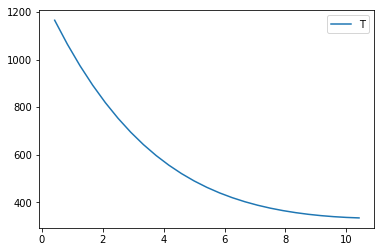

In [8]:
table_data = PrettyTable()
result = calculate()
result[0].pop()
table_data.add_column('T', result[0])
table_data.add_column('x', result[1])
print('Temperature per distance:\n', table_data)

plot.plot(result[1], result[0], label='T')
plot.legend()
plot.savefig('T.png', format='png')
plot.show()